# Data 607 &mdash;  Assignment 1

**Submit a pdf of your .ipynb file to the appropriate D2L dropbox by the due date provided in the course schedule. 
To convert to pdf: File -> Download as HTML. Then you can do Print to PDF to save it as pdf file. Please make sure to add appropriate comments, conclusions and run all cells before converting to pdf format. 

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


### Exercise 1: It's nice to have lots of data!

We have observed that training accuracy is often a poor proxy for generalization accuracy. The purpose of this exercise is to demonstrate, in an example, that training accuracy and generalization accuracy are comparable if the training set is sufficiently large.

Here is a function to generate some synthetic classification data:

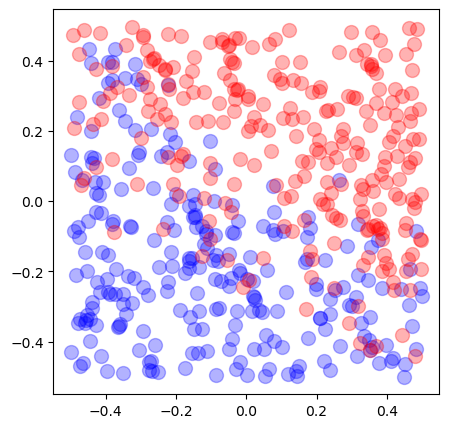

In [68]:
def make_data(size, s=0.15, theta=np.pi/3):
    u = np.array([np.cos(theta), np.sin(theta)])
    X = np.random.uniform(size=(size, 2)) - 0.5
    e = s*np.random.normal(size=size)
    y = 1*(X @ u + e > 0)
    return X, y

X, y = make_data(500)

plt.figure(figsize=(5,5))
ax = plt.gca()
ax.scatter(*X[y == 0].T, color=(0,0,1,0.3), s=100)
ax.scatter(*X[y == 1].T, color=(1,0,0,0.3), s=100)
ax.set_aspect(1)

Let's generate a big testing set for the purpose of estimating generalization  error:

In [69]:
X_te, y_te = make_data(100000) #this is your test set

Now let's create training data($n$):
For each $n$ between $100$ and $100000$ in increments of $100$, train a logistic regression model on each training set of size $n$ generated using `make_data`. Estimate the generalizaton accuracy of this model by the accuracy score on the test set constructed above. On the same axes, plot accuracies on the training set and on testing set versus $n$. Observe the behavior of the accuracy curves for large $n$.

Please label your plot and comment on what you observe on the visualization you just created. 

In [70]:
# Define the sizes of training data
training_sizes = range(100, 100001, 100)
train_accuracies = []
test_accuracies = []
coefficients = []

In [71]:
# Train the logistic regression model on each training set of size n
for n in training_sizes:
    X_train, y_train = make_data(n)
    log_reg = LogisticRegression(random_state=1)
    result = log_reg.fit(X_train, y_train)
    
    # Get the coefficients of the model
    coef = result.coef_
    coefficients.append(coef)
    
    # Accuracy on the training set
    train_accuracy = log_reg.score(X_train, y_train)
    train_accuracies.append(train_accuracy)
    
    # Accuracy on the test set
    test_accuracy = log_reg.score(X_te, y_te)
    test_accuracies.append(test_accuracy)

# Convert coefficients to a numpy array for easier plotting
coefficients = np.array(coefficients).squeeze()


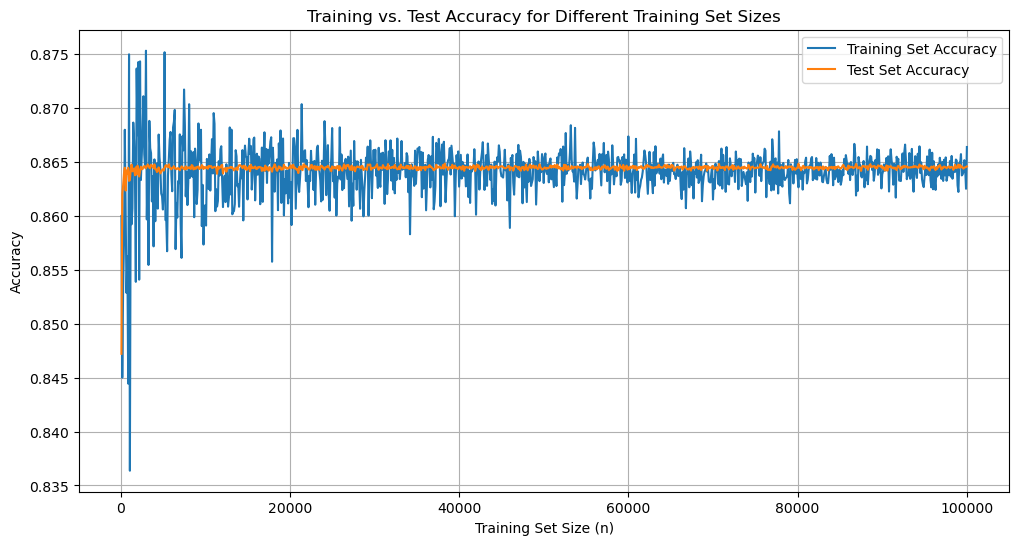

In [72]:
# Plot the accuracies
plt.figure(figsize=(12, 6))
plt.plot(training_sizes, train_accuracies, label='Training Set Accuracy')
plt.plot(training_sizes, test_accuracies, label='Test Set Accuracy')
plt.xlabel('Training Set Size (n)')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy for Different Training Set Sizes')
plt.legend()
plt.grid(True)
plt.show()


**Answer to Exercise 1**

As n increases, the training set accuracy more closely resembles that of the test set accuracy. When n is closer to 0, we see extreme variation in both the test and training set, however the test set plateaus and averages around n = 5000, whereas the training set accuracy remains volatile for much longer (until around n = 40,000). 

### Exercise 2: $k$-nearest neighbor regression

Consider a dataset

$$D=\{(x_1, y_1),\ldots,(x_n, y_n)\},$$

where $x_i\in\mathbb{R}^p$ and $y_i\in\mathbb{R}$.

For $x\in\mathbb{R}^p$, let $i_1(x),\ldots,i_n(x)$ be a permutation of the indices $1,\ldots,n$ such that

$$
\|x-x_{i_1(x)}\| \leq \|x-x_{i_2(x)}\| \leq \cdots \leq \|x-x_{i_n(x)}\|.
$$

In particular, $x_{i_1(x)},\ldots,x_{i_k(x)}$ are the $k$-nearest neighbors of $x$ among $x_1,\ldots,x_n$.

The $k$-nearest neighbor regressor $\hat{f}_D$ associated to $D$ is the function that assigns to $x\in \mathbb{R}^p$ the average of the $y$-values associated to the $k$ nearest neighbors of $x$ among $x_1,\ldots,x_n$:

$$
\hat{f}_D(x) = \frac1k \left( y_{i_1(x)} + \cdots + y_{i_k(x)}\right)
$$

In Scikit-Learn, nearest neighbor regressors are instances of the `KNeighborsRegressor` class, which can be imported from `sklearn.neighbors`. Like its classifier counterpart, `KNeighborsRegressor` takes a keyword argument `n_neighbors`, defaulting to `5`.

Here is some code to generate synthetic $1$-dimensional data for a regression problem. The data is distributed around the curve

$$
f(x) = \sqrt{x}\sin^2(2\pi x).
$$

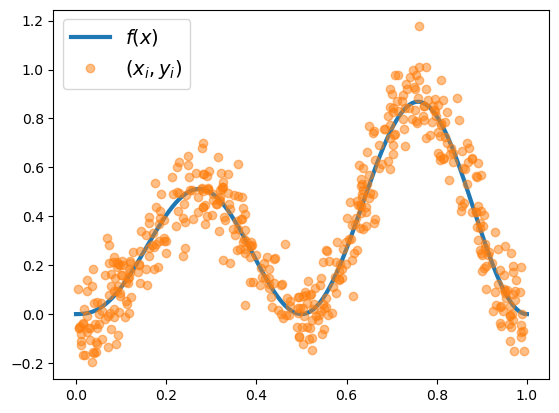

In [45]:
#look in to how we create an algorithm to generate data from above distribution:
def f(x):
    return np.sqrt(x)*np.sin(2*np.pi*x)**2

def make_data(size, s=0.1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    x = np.random.uniform(size=size)
    y = f(x) + s*np.random.normal(size=size)
    return x, y

x, y = make_data(500, random_state=42)
t = np.linspace(0, 1, 1000)
plt.plot(t, f(t), lw=3, label="$f(x)$")
plt.plot(x, y, "o", label="$(x_i, y_i)$", alpha=0.5)
plt.legend(loc="upper left", fontsize=14)
plt.show()

Step 1: Split the dataset (80%/20%) into a training set and a testing set.

Step 2: Identify an optimal value for `n_neighbors` (decide a range)by randomly splitting the train training data(from step 1) 80%/20% into a training subset and a validation subset 200 times, imitating the procedure demonstrated in class for nearest neighbor classifiers. The optimal value for `n_neighbors` is the one that minimizes the average mean squared validation error, averaged over all 200 splittings. You may use $for$  $loops$ or $KFold.split$ to create 200 splits. 

Once you've identified an optimal value for `n_neighbors`, refit the model on the original training set and compute the mean squared error on the original test set.

Step 3: Overlay a plot of your optimal $k$-nearest neighbors regressor $\hat{f}_D$ on the curve $f(x)$.

In [48]:
# Generate synthetic data
X_synthetic, y_synthetic = make_data(1000, s=0.1, random_state=42)

# Reshape X to be a 2D array as expected by scikit-learn
X_synthetic = X_synthetic.reshape(-1, 1)

# Split the data into training and test sets
X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)


In [49]:
# Range of n_neighbors to evaluate
n_neighbors_range = range(1, 21)

# Store the mean squared errors for each n_neighbors
mse_scores_synthetic = []

# Perform repeated splits
n_repeats = 200
for k in n_neighbors_range:
    mse_values = []
    for _ in range(n_repeats):
        X_train_sub_synthetic, X_val_sub_synthetic, y_train_sub_synthetic, y_val_sub_synthetic = train_test_split(X_train_synthetic, y_train_synthetic, test_size=0.2, random_state=None)
        knn_synthetic = KNeighborsRegressor(n_neighbors=k)
        knn_synthetic.fit(X_train_sub_synthetic, y_train_sub_synthetic)
        y_val_pred_synthetic = knn_synthetic.predict(X_val_sub_synthetic)
        mse_values.append(mean_squared_error(y_val_sub_synthetic, y_val_pred_synthetic))
    mse_scores_synthetic.append(np.mean(mse_values))

# Find the optimal k (which minimizes the mean squared error)
optimal_k_synthetic = n_neighbors_range[np.argmin(mse_scores_synthetic)]
print(f"The optimal number of neighbors for synthetic data is: {optimal_k_synthetic}")


The optimal number of neighbors for synthetic data is: 20


In [51]:
# Refit the model on the original training set with the optimal number of neighbors
knn_optimal_synthetic = KNeighborsRegressor(n_neighbors=optimal_k_synthetic)
knn_optimal_synthetic.fit(X_train_synthetic, y_train_synthetic)

KNeighborsRegressor(n_neighbors=20)

In [52]:
# Compute the mean squared error on the original test set
y_test_pred_synthetic = knn_optimal_synthetic.predict(X_test_synthetic)
test_mse_synthetic = mean_squared_error(y_test_synthetic, y_test_pred_synthetic)
print(f'Mean Squared Error on the synthetic test set: {test_mse_synthetic}')

Mean Squared Error on the synthetic test set: 0.00920216892130023


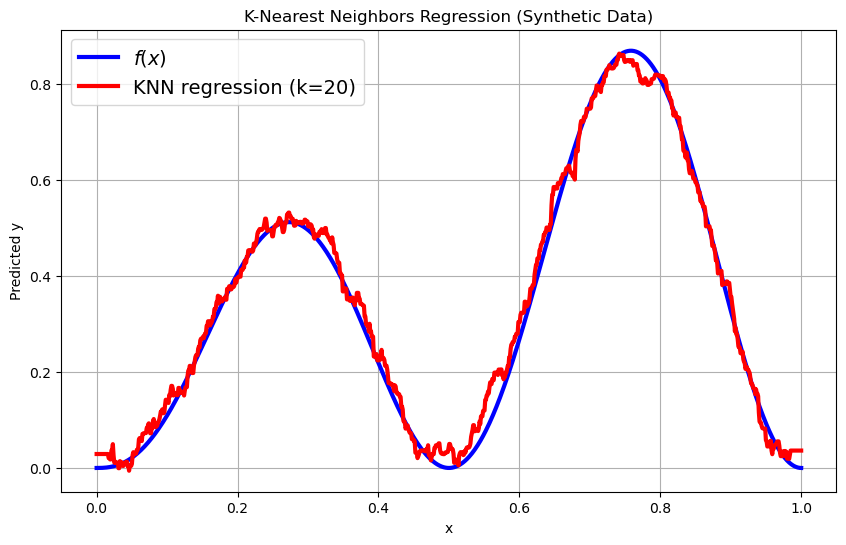

In [75]:
# Plot the k-nearest neighbors regression predictions overlaying the curve f(x)
t = np.linspace(0, 1, 1000).reshape(-1, 1)
y_true_synthetic = f(t).flatten()  # Flatten y_true to make sure it's a 1D array
y_pred_synthetic = knn_optimal_synthetic.predict(t)


plt.figure(figsize=(10, 6))
plt.plot(t, y_true_synthetic, lw=3, label="$f(x)$", color='blue')
plt.plot(t, y_pred_synthetic, lw=3, label=f'KNN regression (k={optimal_k_synthetic})', color='red')
plt.xlabel('x')
plt.ylabel('Predicted y')
plt.title('K-Nearest Neighbors Regression (Synthetic Data)')
plt.legend(loc="upper left", fontsize=14)
plt.grid(True)
plt.show()

### Exercise 3: Diabetes Data

In this exercise, we use the diabetes dataset built into Scikit-Learn. See the [User Guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) for information on the dataset.

1. Split the dataset 80%/20% into a training set and a testing set.

2. Fit a linear regression model to the training set. Report the mean squared error on the test set.

3. Using the method of Exercise 2, find an optimal value of `n_neighbors` for a `KNeighborsRegressor` fit to the training data. Once you've identified an optimal value for `n_neighbors`, refit the model on the original training set and compute the mean squared error on the test set.

4. How do the linear regression model and the $k$-nearest neighbors model compare?


In [57]:

# Load the diabetes dataset
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target
# Split the dataset 80%/20% into a training set and a testing set
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(X_diabetes, y_diabetes, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_diabetes = scaler.fit_transform(X_train_diabetes)
X_test_diabetes = scaler.transform(X_test_diabetes)


In [58]:
# Fit linear regression to the diabetes dataset
linear_reg_diabetes = LinearRegression()
linear_reg_diabetes.fit(X_train_diabetes, y_train_diabetes)
y_test_pred_diabetes_lr = linear_reg_diabetes.predict(X_test_diabetes)
mse_diabetes_lr = mean_squared_error(y_test_diabetes, y_test_pred_diabetes_lr)
print(f'Linear Regression Mean Squared Error on the diabetes test set: {mse_diabetes_lr}')


Linear Regression Mean Squared Error on the diabetes test set: 2900.1936284934823


In [59]:
# Hyperparameter optimization for k-neighbors
k_range_diabetes = range(1, 21)
mse_scores_diabetes = []

for k in k_range_diabetes:
    mse_values = []
    for _ in range(n_repeats):
        X_train_sub_diabetes, X_val_sub_diabetes, y_train_sub_diabetes, y_val_sub_diabetes = train_test_split(X_train_diabetes, y_train_diabetes, test_size=0.2, random_state=None)
        knn_diabetes = KNeighborsRegressor(n_neighbors=k)
        knn_diabetes.fit(X_train_sub_diabetes, y_train_sub_diabetes)
        y_val_pred_diabetes = knn_diabetes.predict(X_val_sub_diabetes)
        mse_values.append(mean_squared_error(y_val_sub_diabetes, y_val_pred_diabetes))
    mse_scores_diabetes.append(np.mean(mse_values))

# Find the optimal k (which minimizes the mean squared error)
optimal_k_diabetes = k_range_diabetes[np.argmin(mse_scores_diabetes)]
print(f"The optimal number of neighbors for diabetes data is: {optimal_k_diabetes}")

The optimal number of neighbors for diabetes data is: 14


In [60]:
# Refit the model on the original training set with the optimal number of neighbors
knn_optimal_diabetes = KNeighborsRegressor(n_neighbors=optimal_k_diabetes)
knn_optimal_diabetes.fit(X_train_diabetes, y_train_diabetes)

KNeighborsRegressor(n_neighbors=14)

In [61]:
# Compute the mean squared error on the original test set
y_test_pred_diabetes_knn = knn_optimal_diabetes.predict(X_test_diabetes)
test_mse_diabetes_knn = mean_squared_error(y_test_diabetes, y_test_pred_diabetes_knn)
print(f'KNN Regression Mean Squared Error on the diabetes test set: {test_mse_diabetes_knn}')


KNN Regression Mean Squared Error on the diabetes test set: 3098.91097225407


**Answer to Step 4**

The linear regression boasted an MSE of 2900.1936, while the KNeighbours regressor method boasted an MSE of 3098.9109. This means that the linear regression is slightly better fit for the type of data, when compared to the K-Nearest Regression.

### Exercise 4: Breast Cancer Data

In this exercise, we use the breast cancer Wisconsin dataset built into Scikit-Learn. See the [User Guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset) for information on the dataset. Note that this dataset is for classification rather than regression.

1. Split the dataset 80%/20% into a training set and a testing set.

2. Fit a logistic regression model to the training set. Report the classification accuracy on the test set.

3. Using a cross-validated grid search (`GridSeachCV`), find an optimal support vector classifier fit to the training set. Support vector classifiers are instances of the `SVC` class, importable from `sklearn.svm`. Search over values of the parameter `C` in `[0.001, 0.01, 0.1, 1, 10, 100, 1000]` and `kernel` in `["linear", "rbf", "poly"]`. Report the best values for `C` and `kernel` and the classification accuracy on the test set associated to the best model.

4. How do the logistic regression classifier and the support vector classifier compare?



In [62]:
#import  breast cancer data
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
data = load_breast_cancer()
x =data.data
y = data.target



In [63]:
# Split the dataset into training and testing sets (80/20 split)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
#fit logistic regression
log_reg = LogisticRegression(random_state = 1)
result = log_reg.fit(X_train, y_train)

y_pred2 = log_reg.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred2)}')

Accuracy Score: 0.9736842105263158


In [65]:
# Set the parameter grid for GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly']
}
# Initialize a support vector classifier
svc = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')

In [66]:
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")


Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.9758241758241759


**Answer to Step 4**

The SVC has a slightly higher accuracy, at 97.6%. whereas the logitstic regression shows an accuracy of 97.4%. Even with the SVC showing slightly better accuracy, both models boast a respectable accuracy in the high 90s.